In [1]:

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, train_test_split_stratified
from models.inceptiontime import LitInceptionTimeModel
from models.transformer import TransformerClassifier, LitTimeSeriesClassifier
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.misc import set_random_state
from utils.path import config_path, log_path, checkpoint_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Dataloader Parameters
BATCH_SIZE_TRIALS = 8

### Load Configs

In [2]:
with open(config_path.joinpath('leif.yaml')) as reader:
    processor_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('transformer.yaml')) as reader:
    transformer_config = load_yaml(reader, Loader=FullLoader)

### Initialize the processor

In [3]:
# Configure processor
processor = Leif(processor_config)

### Prepare Data (trials)
**TODO We cannot ensure same split between segments and trials, redo so the same dataset has both.**

loading files: 0files [00:00, ?files/s]

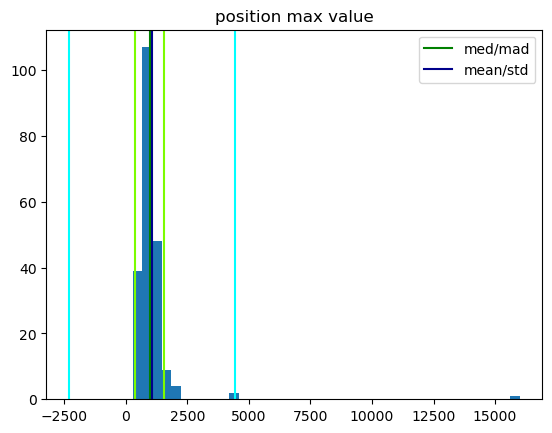

skipped 14 files (position max value outlier)


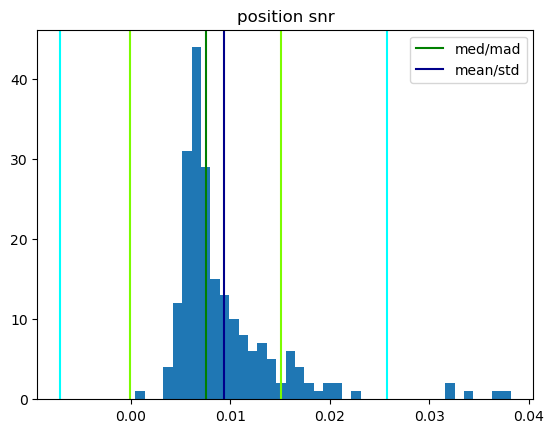

skipped 19 files (position snr outlier)


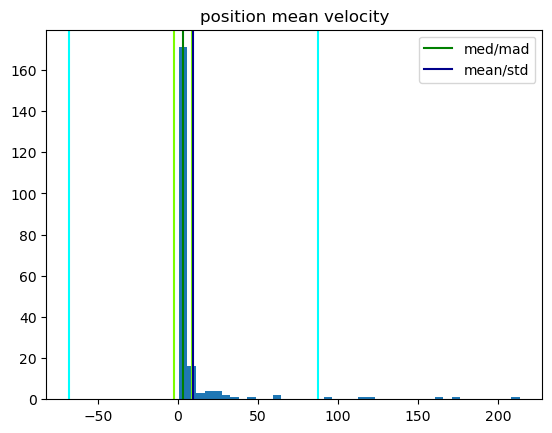

skipped 22 files (position mean velocity outlier)


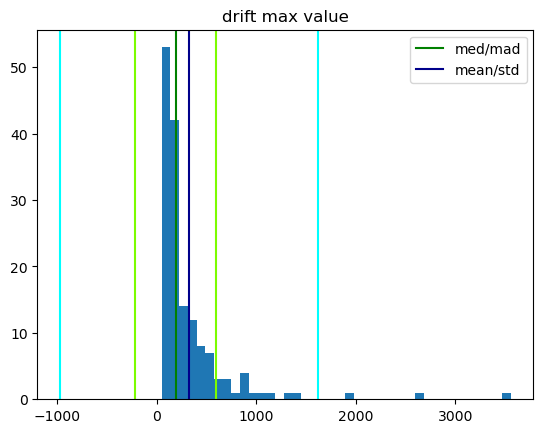

skipped 17 files (drift max value outlier)


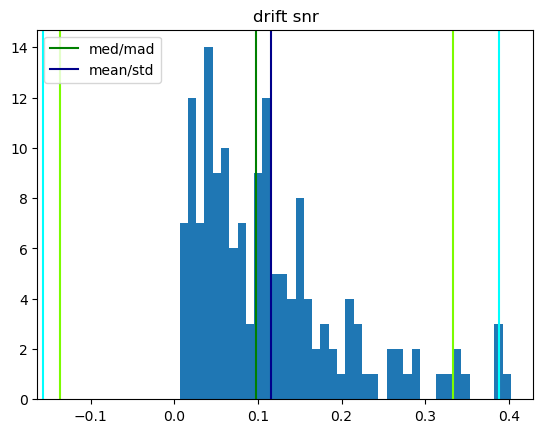

skipped 5 files (drift snr outlier)


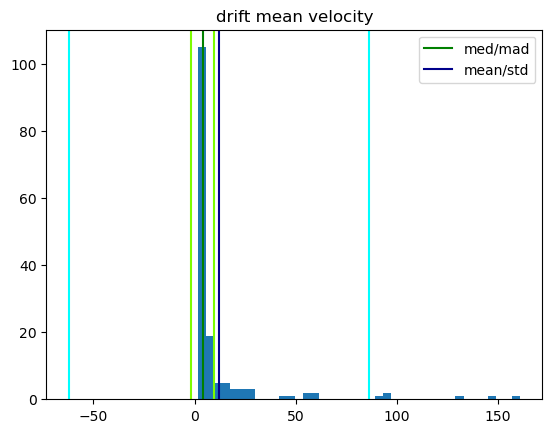

skipped 23 files (drift mean velocity outlier)
skipped 1 files (no target movement)


segmenting time series: 100%|██████████| 109/109 [00:06<00:00, 15.75ts/s]


loading files: 0files [00:00, ?files/s]

segmenting time series: 100%|██████████| 89/89 [00:05<00:00, 15.90ts/s]


In [4]:
# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True, bundle_as_trials=True, use_triplets=False)
train_ds, val_ds = train_test_split_stratified(train_val_ds, test_size=0.2)
test_ds = KIDataset(data_processor=processor, train=False, bundle_as_trials=True, use_triplets=False)

# Binarize dataset after split to make sure split is stratified w.r.t all three classes
if BINARY_CLF:
    for ds in [train_ds, val_ds, test_ds]:
        binarize(ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE_TRIALS,
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE_TRIALS)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_TRIALS)

### Initialize and Load Models

In [5]:
inception_time = LitInceptionTimeModel.load_from_checkpoint(checkpoint_path.joinpath('epoch=46-step=282.ckpt'))

# Freeze parameters of the encoder
inception_time.freeze()

# Initialize transformer decoder
clf = TransformerClassifier(in_features=inception_time.out_dim, **transformer_config)

# Initialize lit time series classifier
model = LitTimeSeriesClassifier(encoder=inception_time, decoder=clf, feature_dim=inception_time.out_dim, lr=1e-5,
                                wd=1e-1)

### Train transformer classifier

In [6]:
trainer = Trainer(accelerator='auto',
                  max_epochs=500,
                  logger=TensorBoardLogger(save_dir=log_path),
                  callbacks=[LearningRateMonitor(),
                             ModelCheckpoint(dirpath=checkpoint_path, monitor='val_loss', every_n_epochs=1)],
                  log_every_n_steps=1)

# Train the joint classifier
trainer.fit(model, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\hejpa\Documents\GitHub\eye-track-pdc\checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                  | Params
--------------------------------------------------
0 | encoder | LitInceptionTimeModel | 61.1 K
1 | decoder | TransformerClassifier | 281 K 
2 | loss_fn | BCEWithLogitsLoss     | 0     
--------------------------------------------------
281 K     Trainable params
61.1 K    Non-trainable params
342 K     Total params
1.371     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\torch\nn\modules\conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  self.padding, self.dilation, self.groups)
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
